# Data Story

This jupyter notebook explains the entire process that took place when analyzing the rainfall data and predicting rainfall data for the next 50 years. It first begins with exploratory data analysis, then moves to creating a Sarima model, then finishes by predicting the next 50 years of monthly rainfall from the sarima model. 

## Exploratory Data Analysis

In this section of the notebook, I will be exploring the data and answering the following questions:

   1. Is there something intereseting to count?
   2. Are there any trends (e.g. high, low, increasing, decreasing, anomalies)?
   3. Are there any valuable comparisons between two related quantities?
  
I used histograms, bar plots, scatterplots, and time-series plots to answer the following questions:

   4. Are there any insights from the data?
   5. Are there any correlations? 
   6. What is a hypothesis that can be taken further?
   7. What other questions arise from these insights and correlations?
   
After answering these questions, I provide a link to a presentation that uses text and plots to tell the compelling story of my data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import statsmodels.api as sm
import visualization as vz
import warnings
from api_key import APIKEY
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from textwrap import wrap
from itertools import combinations
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import defaultdict
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
warnings.filterwarnings("ignore")

file = '../data/manipulated_data/rainfalldata.csv'
rd = pd.read_csv(file)
file2 = '../data/manipulated_data/ncrainfalldata.csv'
ncrd = pd.read_csv(file2)
file3 = '../data/raw_data/latlong.csv'
latlong = pd.read_csv(file3)
# shapefile = '../data/raw_data/shapefile5/2010_Census_Blocks.shp'
# gdf = gpd.read_file(shapefile)


rd.Date = pd.to_datetime(rd.Date)
rd = rd.set_index('Date')
ncrd.Date = pd.to_datetime(ncrd.Date)
ncrd = ncrd.set_index('Date')

In [2]:
# towns = 
# gdf.head()
# gotem = []
# for l in locs:
#     if l in towns:
#         gotem.append(l)
# len(gotem)
# towns

### Viewing the datasets.

In [3]:
rd.head()

,"RALEIGH, NC","FAYETTEVILLE, NC","ALBEMARLE, NC","ARCOLA, NC","ASHEBORO, NC","BURLINGTON, NC","CARTHAGE, NC","CHAPEL HILL, NC","CLAYTON, NC","DUNN, NC",...,"ROGERSVILLE 1 NE, TN","SODDY DAISY-MOWBRAY MTN, TN","SPRING CITY, TN","TAZEWELL, TN","TOWNSEND 5S, TN","KING, NC","ABINGDON 3S, VA","WISE 1SE, VA","JOHN KERR DAM, VA","EMPORIA, VA"
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,4.39,3.77,4.87,4.01,4.65,4.43,4.950000,4.08,3.57,4.04,...,5.15,5.251365,5.441905,6.06,5.487946,4.359094,4.22,4.243739,4.76,5.34
1980-02-01,1.91,1.77,0.84,1.29,1.55,1.82,1.210000,2.05,2.03,2.02,...,1.28,2.436904,1.940698,2.43,1.739744,1.104737,1.48,1.150000,1.45,1.27
1980-03-01,5.87,5.93,11.39,5.59,6.33,5.69,6.813333,6.28,5.19,5.86,...,6.50,13.298871,12.600485,7.51,10.810524,6.604737,5.84,4.320000,4.02,3.24
1980-04-01,1.97,3.61,3.49,1.94,1.86,2.79,2.518667,2.32,2.94,2.68,...,3.54,4.734908,4.289646,3.37,4.727123,4.352105,3.51,4.030000,3.24,2.73
1980-05-01,2.33,1.77,5.14,2.24,4.36,3.86,3.244000,4.50,2.30,2.05,...,2.80,4.829126,4.637170,3.79,4.585172,4.374211,4.08,2.880000,4.01,4.66


In [4]:
ncrd.head()

,"RALEIGH, NC","FAYETTEVILLE, NC","ALBEMARLE, NC","ARCOLA, NC","ASHEBORO, NC","BURLINGTON, NC","CARTHAGE, NC","CHAPEL HILL, NC","CLAYTON, NC","DUNN, NC",...,"JEFFERSON 2 E, NC","MOUNT AIRY 2 W, NC","NORTH WILKESBORO, NC","REIDSVILLE 2 NW, NC","TRANSOU, NC","W. KERR SCOTT RESV., NC","YADKINVILLE 6 E, NC","HAYESVILLE 1 NE, NC","MURPHY 4ESE, NC","KING, NC"
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,4.39,3.77,4.87,4.01,4.65,4.43,4.950000,4.08,3.57,4.04,...,3.41,4.19,4.56,3.46,3.99,4.38,4.39,6.415914,4.06,4.359094
1980-02-01,1.91,1.77,0.84,1.29,1.55,1.82,1.210000,2.05,2.03,2.02,...,1.11,0.57,0.71,1.02,0.97,0.86,1.40,2.116355,1.48,1.104737
1980-03-01,5.87,5.93,11.39,5.59,6.33,5.69,6.813333,6.28,5.19,5.86,...,6.70,6.68,7.88,5.13,7.38,8.29,7.15,14.349826,14.17,6.604737
1980-04-01,1.97,3.61,3.49,1.94,1.86,2.79,2.518667,2.32,2.94,2.68,...,7.46,6.88,6.24,2.92,11.39,6.68,4.45,5.498276,5.79,4.352105
1980-05-01,2.33,1.77,5.14,2.24,4.36,3.86,3.244000,4.50,2.30,2.05,...,5.29,5.14,5.31,3.18,3.86,3.64,4.19,6.144035,4.98,4.374211


### Visualizing the average rainfall per month for Raleigh, NC as a bar graph using the standard error of the mean for error bars. 


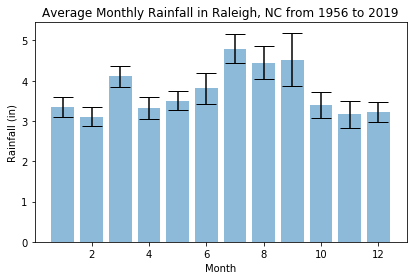

In [5]:
monthavg = []
monthsem = []
monthstd = []
for i in range(1,13):
    monthavg.append(np.mean(rd['RALEIGH, NC'][rd.index.month == i]))
    monthsem.append(stats.sem(rd['RALEIGH, NC'][rd.index.month == i]))
    monthstd.append(np.std(rd['RALEIGH, NC'][rd.index.month == i]))
    
fig, ax = plt.subplots()
ax.bar(rd.index.month.unique(), monthavg, yerr = monthsem, alpha=0.5, ecolor='black', capsize=10)
ax.set_title('Average Monthly Rainfall in Raleigh, NC from 1956 to 2019')
ax.set_xlabel('Month')
ax.set_ylabel('Rainfall (in)')
plt.tight_layout()
plt.savefig('raleighmonthly.jpg')
plt.show()

### Resampling the data as average rainfall per year and comparing two different sites


In [6]:
rdyearavg = rd.resample('Y').mean()
rdyearavg.head()

,"RALEIGH, NC","FAYETTEVILLE, NC","ALBEMARLE, NC","ARCOLA, NC","ASHEBORO, NC","BURLINGTON, NC","CARTHAGE, NC","CHAPEL HILL, NC","CLAYTON, NC","DUNN, NC",...,"ROGERSVILLE 1 NE, TN","SODDY DAISY-MOWBRAY MTN, TN","SPRING CITY, TN","TAZEWELL, TN","TOWNSEND 5S, TN","KING, NC","ABINGDON 3S, VA","WISE 1SE, VA","JOHN KERR DAM, VA","EMPORIA, VA"
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-31,2.970000,3.840000,3.676667,2.802500,3.323333,3.900833,3.569909,3.980833,3.131111,3.403333,...,3.383333,4.120378,3.933438,3.381667,4.072633,3.393764,3.357500,3.230709,2.908737,2.849167
1981-12-31,3.031667,2.702500,4.341667,3.051667,3.629167,3.539167,3.113333,3.313333,2.915833,3.705000,...,3.518333,3.923675,3.821139,4.027500,3.902181,3.257617,3.777500,3.768333,2.835000,2.431389
1982-12-31,3.695833,3.785833,4.505000,4.022500,4.260000,4.365000,4.667500,4.786667,4.304167,4.302500,...,4.303333,5.053252,5.007462,4.714444,5.026721,3.944561,4.777500,4.174167,4.112500,3.731667
1983-12-31,3.935833,4.139167,4.105000,4.051667,3.796667,3.967500,4.242500,5.015463,4.380000,3.988333,...,3.424167,4.658825,4.384312,3.490833,4.374961,4.060439,3.410833,3.394167,4.061667,3.985000
1984-12-31,3.855833,3.815000,4.278333,4.715000,3.752500,4.038333,4.821667,4.200000,3.576875,4.560833,...,3.660278,4.690966,4.595042,4.356667,4.493751,3.942071,3.509167,3.626667,4.117500,3.645833


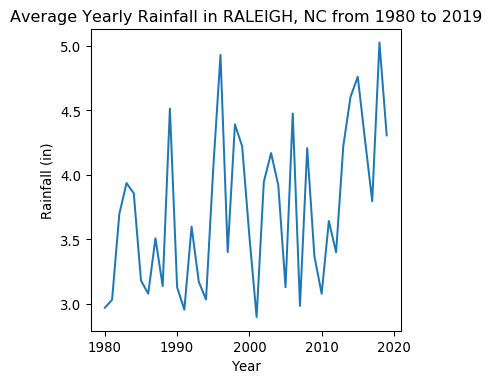

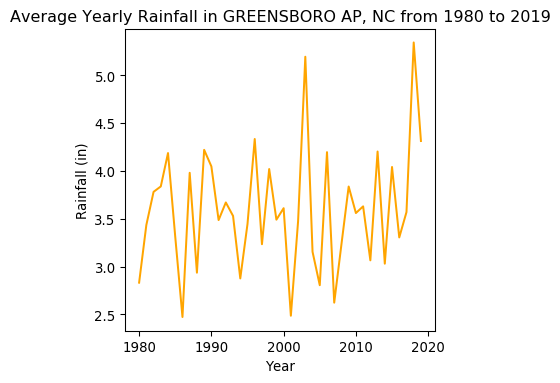

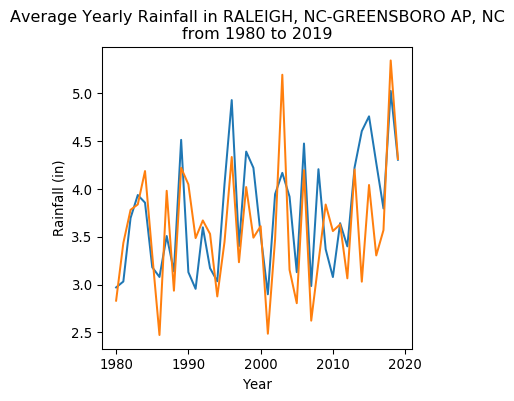

In [7]:
def yearlyavgfigs(df, loc, **keyword_parameters):
    ''' this function takes in a dataframe and a location (column) and displays the average yearly rainfall 
    for each location. Only can take up to 2 locations
    '''
    plt.figure(figsize = (400/96, 400/96),dpi=96)
    if len(loc) == 1:
        if ('color' in keyword_parameters):
            plt.plot(df.index.year, df[loc[0]], keyword_parameters['color'])
        else:
            plt.plot(df.index.year, df[loc[0]])
        plt.title('Average Yearly Rainfall in ' + loc[0] + ' from 1980 to 2019')
    else:
        plt.plot(df.index.year, df[loc[0]])
        plt.plot(df.index.year, df[loc[1]])
        plt.title("\n".join(wrap('Average Yearly Rainfall in ' + loc[0] + '-' + loc[1] + ' from 1980 to 2019', 
                                 60)))
    plt.xlabel('Year')
    plt.ylabel('Rainfall (in)')
    plt.show()
yearlyavgfigs(rdyearavg, ['RALEIGH, NC'])
yearlyavgfigs(rdyearavg, ['GREENSBORO AP, NC'], color='orange')
yearlyavgfigs(rdyearavg, ['RALEIGH, NC', 'GREENSBORO AP, NC'])

### There is a seasonality to rainfall amounts throughout the year. The following steps utilize seasonal decomposition to investigate the how often the seasonality occurred

In [8]:
plt.rcParams["figure.figsize"] = (50,50)
plt.rcParams["font.size"] = 32.0

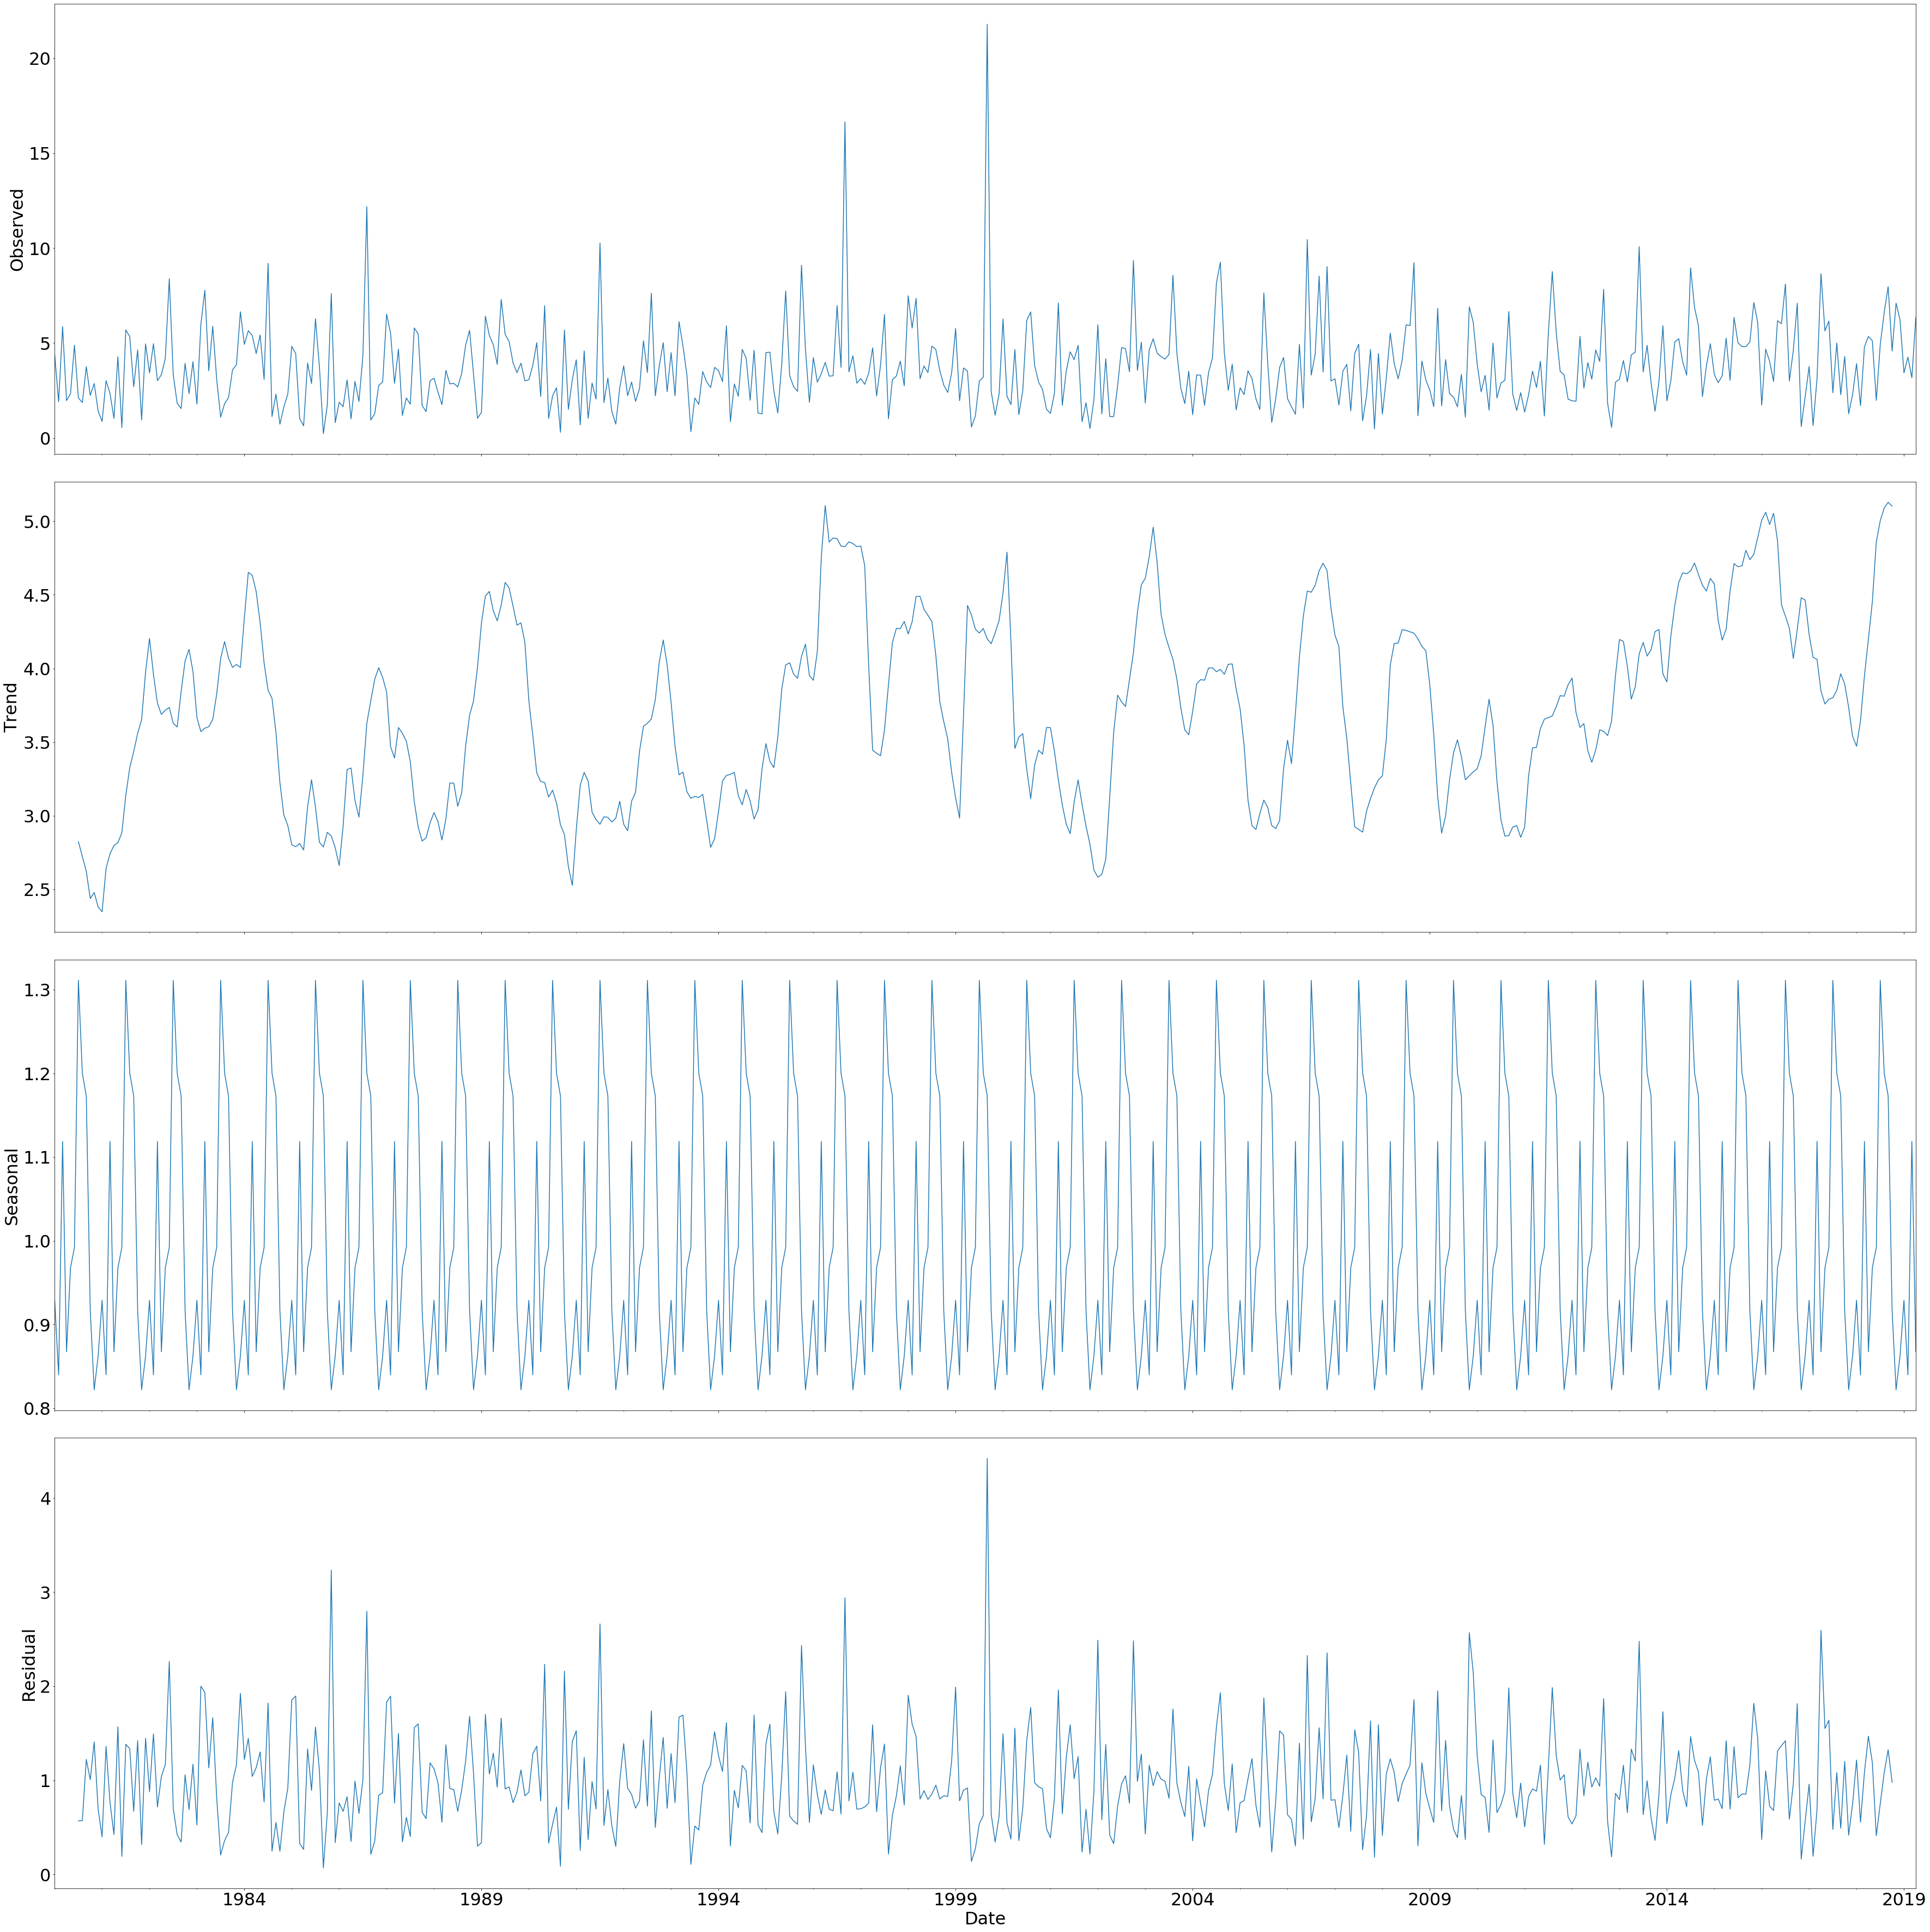

In [9]:
result = seasonal_decompose(rd['RALEIGH, NC'], freq=12, model='multiplicative')
result.plot()
plt.savefig('seasonalityral.jpg')
plt.show()

### It appears that there may be a slight increase towards the end of the sample towards an increase in rainfall amounts. Therefore, the following cells looks into whether there is a positive trend in the dataset. 

In [10]:
t = result.trend
t2col = t.reset_index()
t2col = t2col.dropna()
t2col = t2col.reset_index()
x = np.array(t2col.index).reshape(-1,1)

In [11]:
tdf = pd.DataFrame(t)
tdf = tdf.dropna()
y = np.array(tdf['RALEIGH, NC'])

### As shown by the Least Squares model below. The best fit line for the trend data is a 0 degree line with one coefficient. Basically showing that there is no positive or negative correlation in rainfall over the past 40 years in Raleigh, NC. 

In [12]:
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.781
Model:                            OLS   Adj. R-squared (uncentered):              0.781
Method:                 Least Squares   F-statistic:                              1641.
Date:                Thu, 12 Sep 2019   Prob (F-statistic):                   1.20e-153
Time:                        20:30:29   Log-Likelihood:                         -913.18
No. Observations:                 460   AIC:                                      1828.
Df Residuals:                     459   BIC:                                      1832.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0126      0.000     40.505      0.000       0.012       0.013
==============================================================================
Omnibus:                      141.842   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.280
Skew:                           0.097   Prob(JB):                     8.81e-06
Kurtosis:                       1.915   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
plt.rcParams["font.size"] = 12.0

### A look at the correlations between only 25 locations. "rd.iloc" can be manipulated to be any other set of 25 locations to see the correlations between those locations

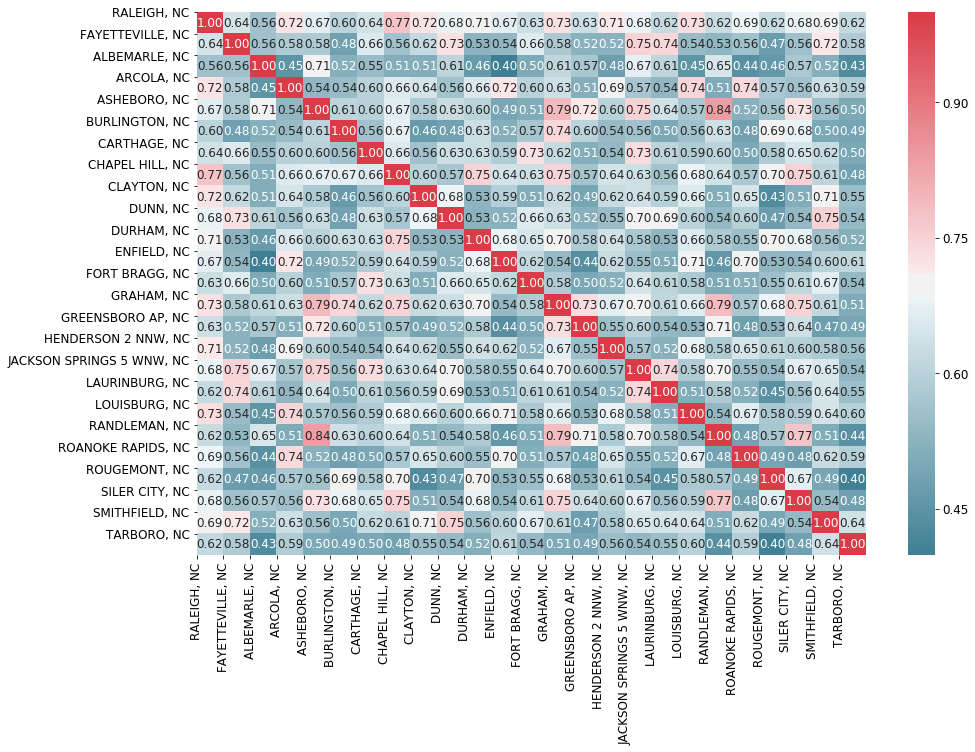

In [14]:
#nc heatmap
rd_fr25 = rd.iloc[:,0:25]
vz.get_corr_heat_map(rd_fr25, ignore_cancelled = False)

# Correlation

Beginning with autocorrelation of all target (NC) locations only

In [15]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    rs = int(result.size/2)
    return result[rs:]

In [16]:
plt.rcParams["font.size"] = 24.0

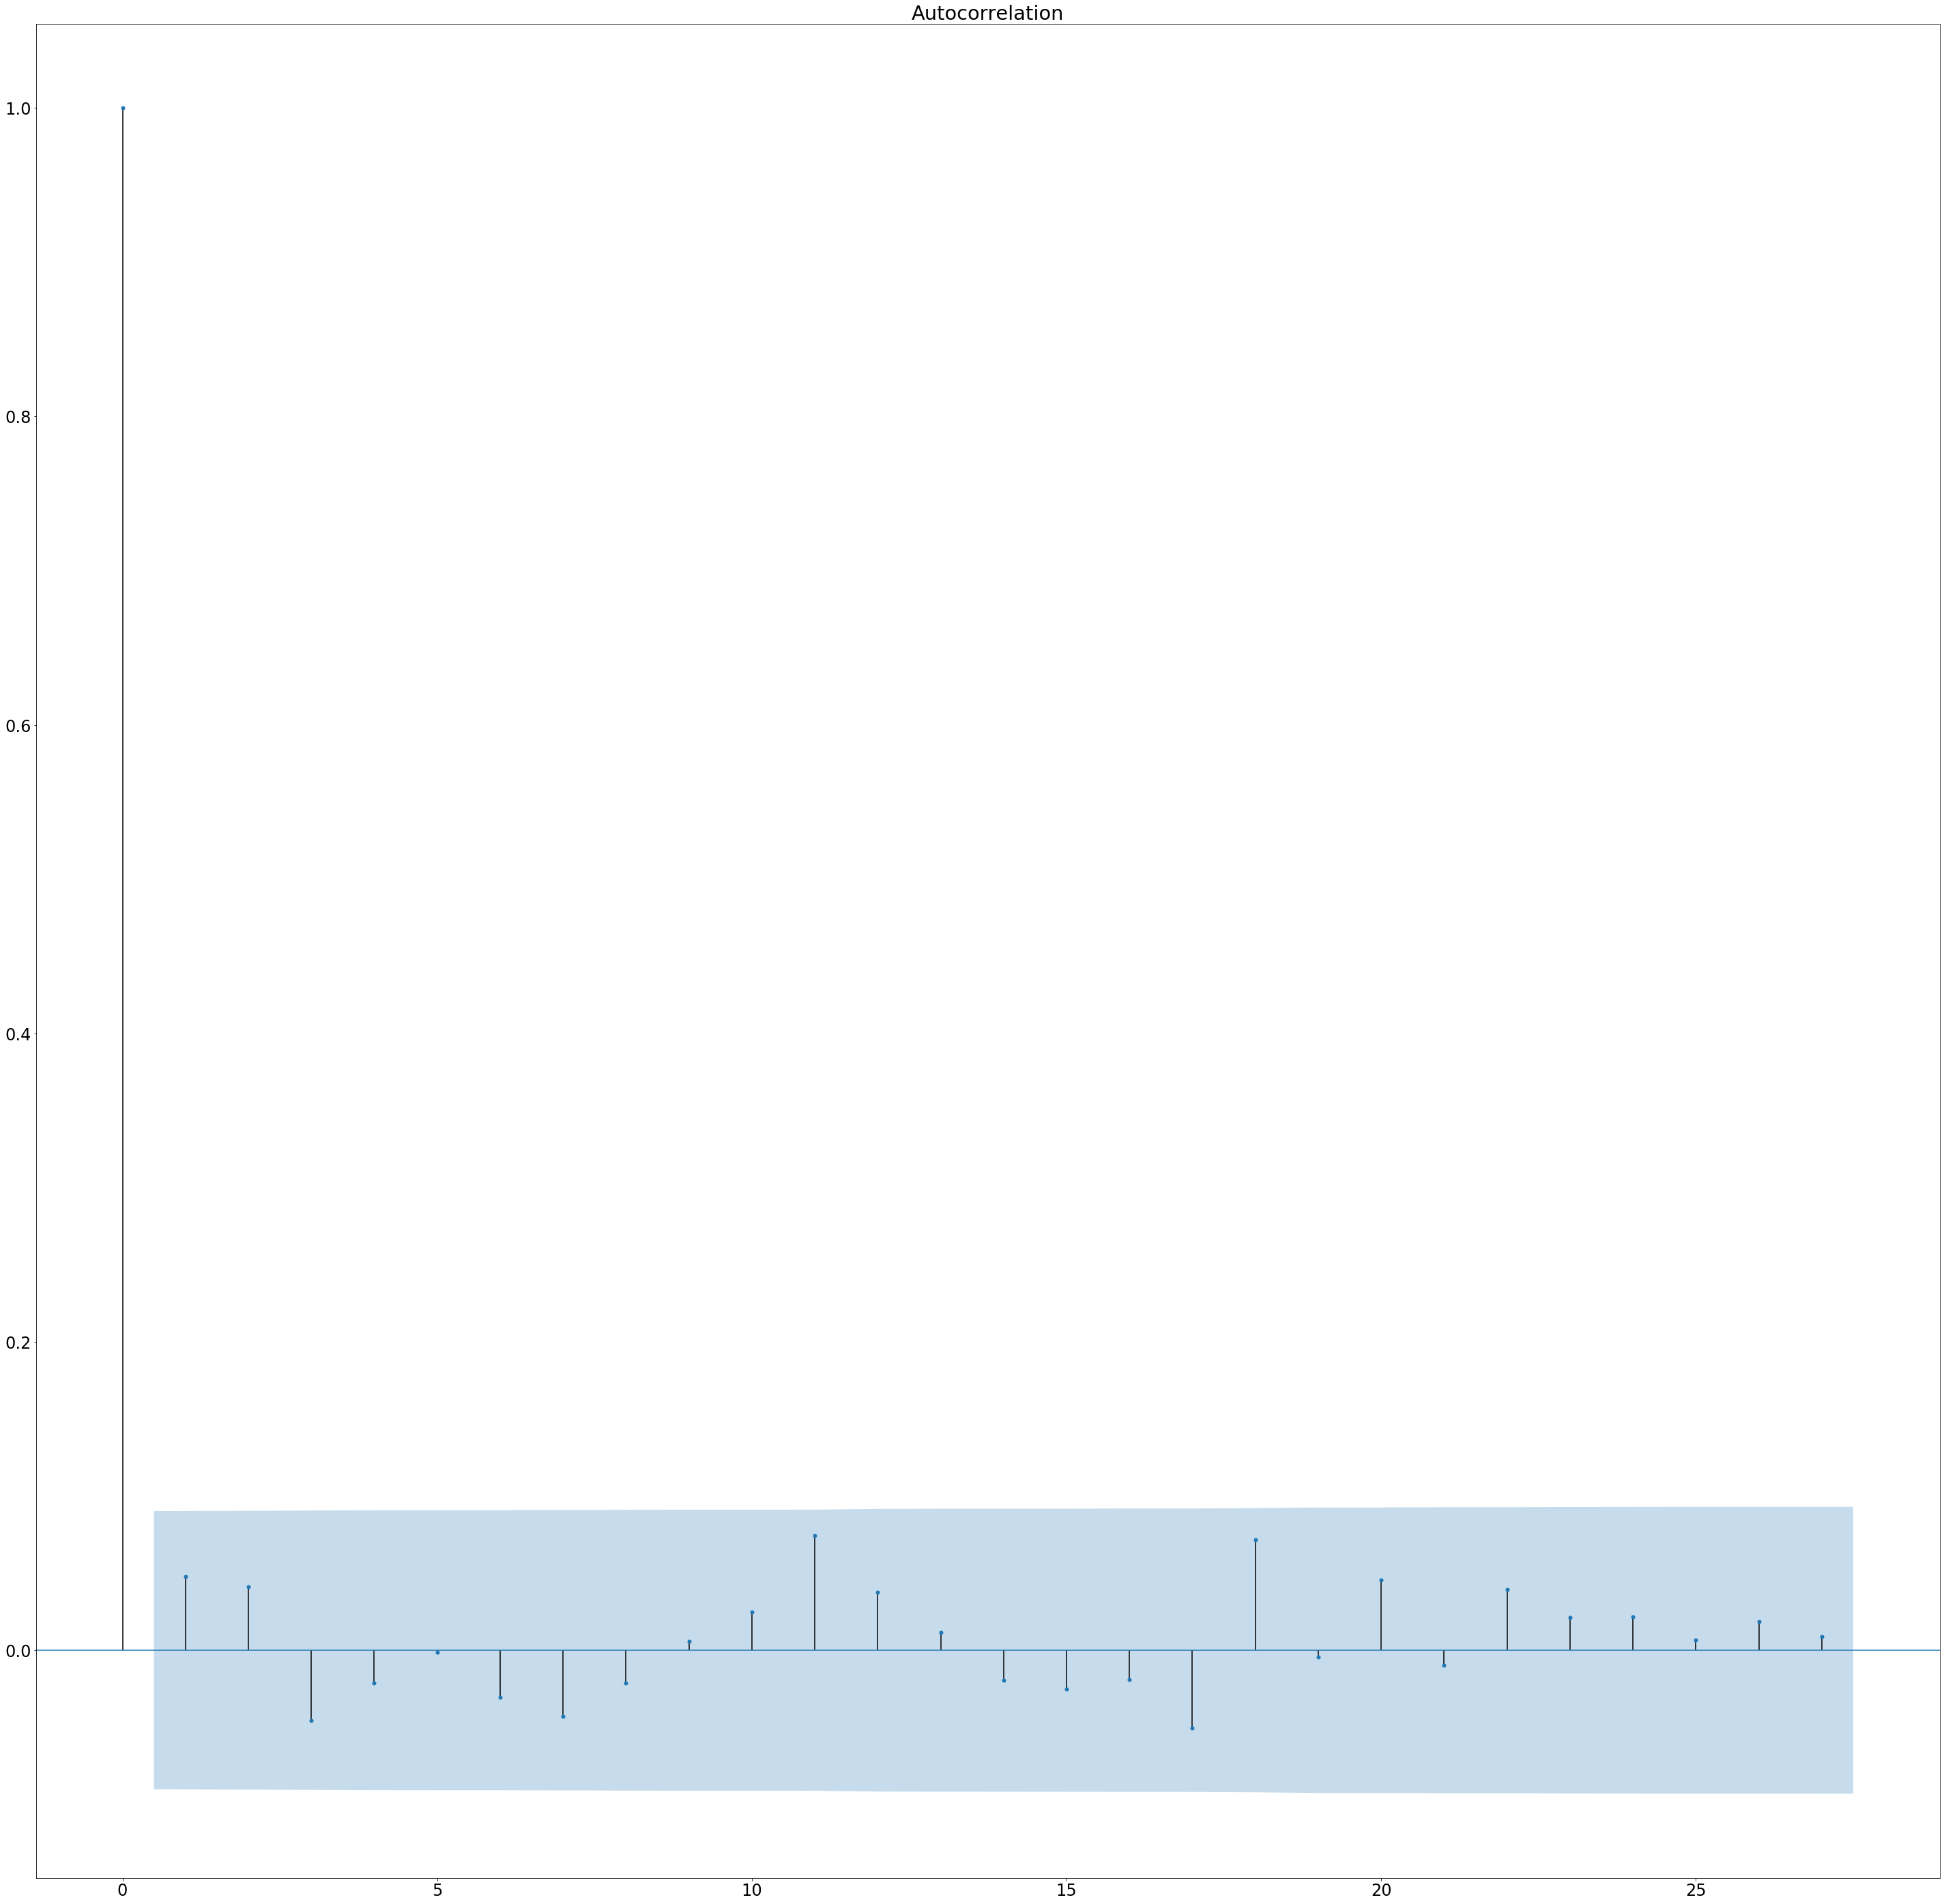

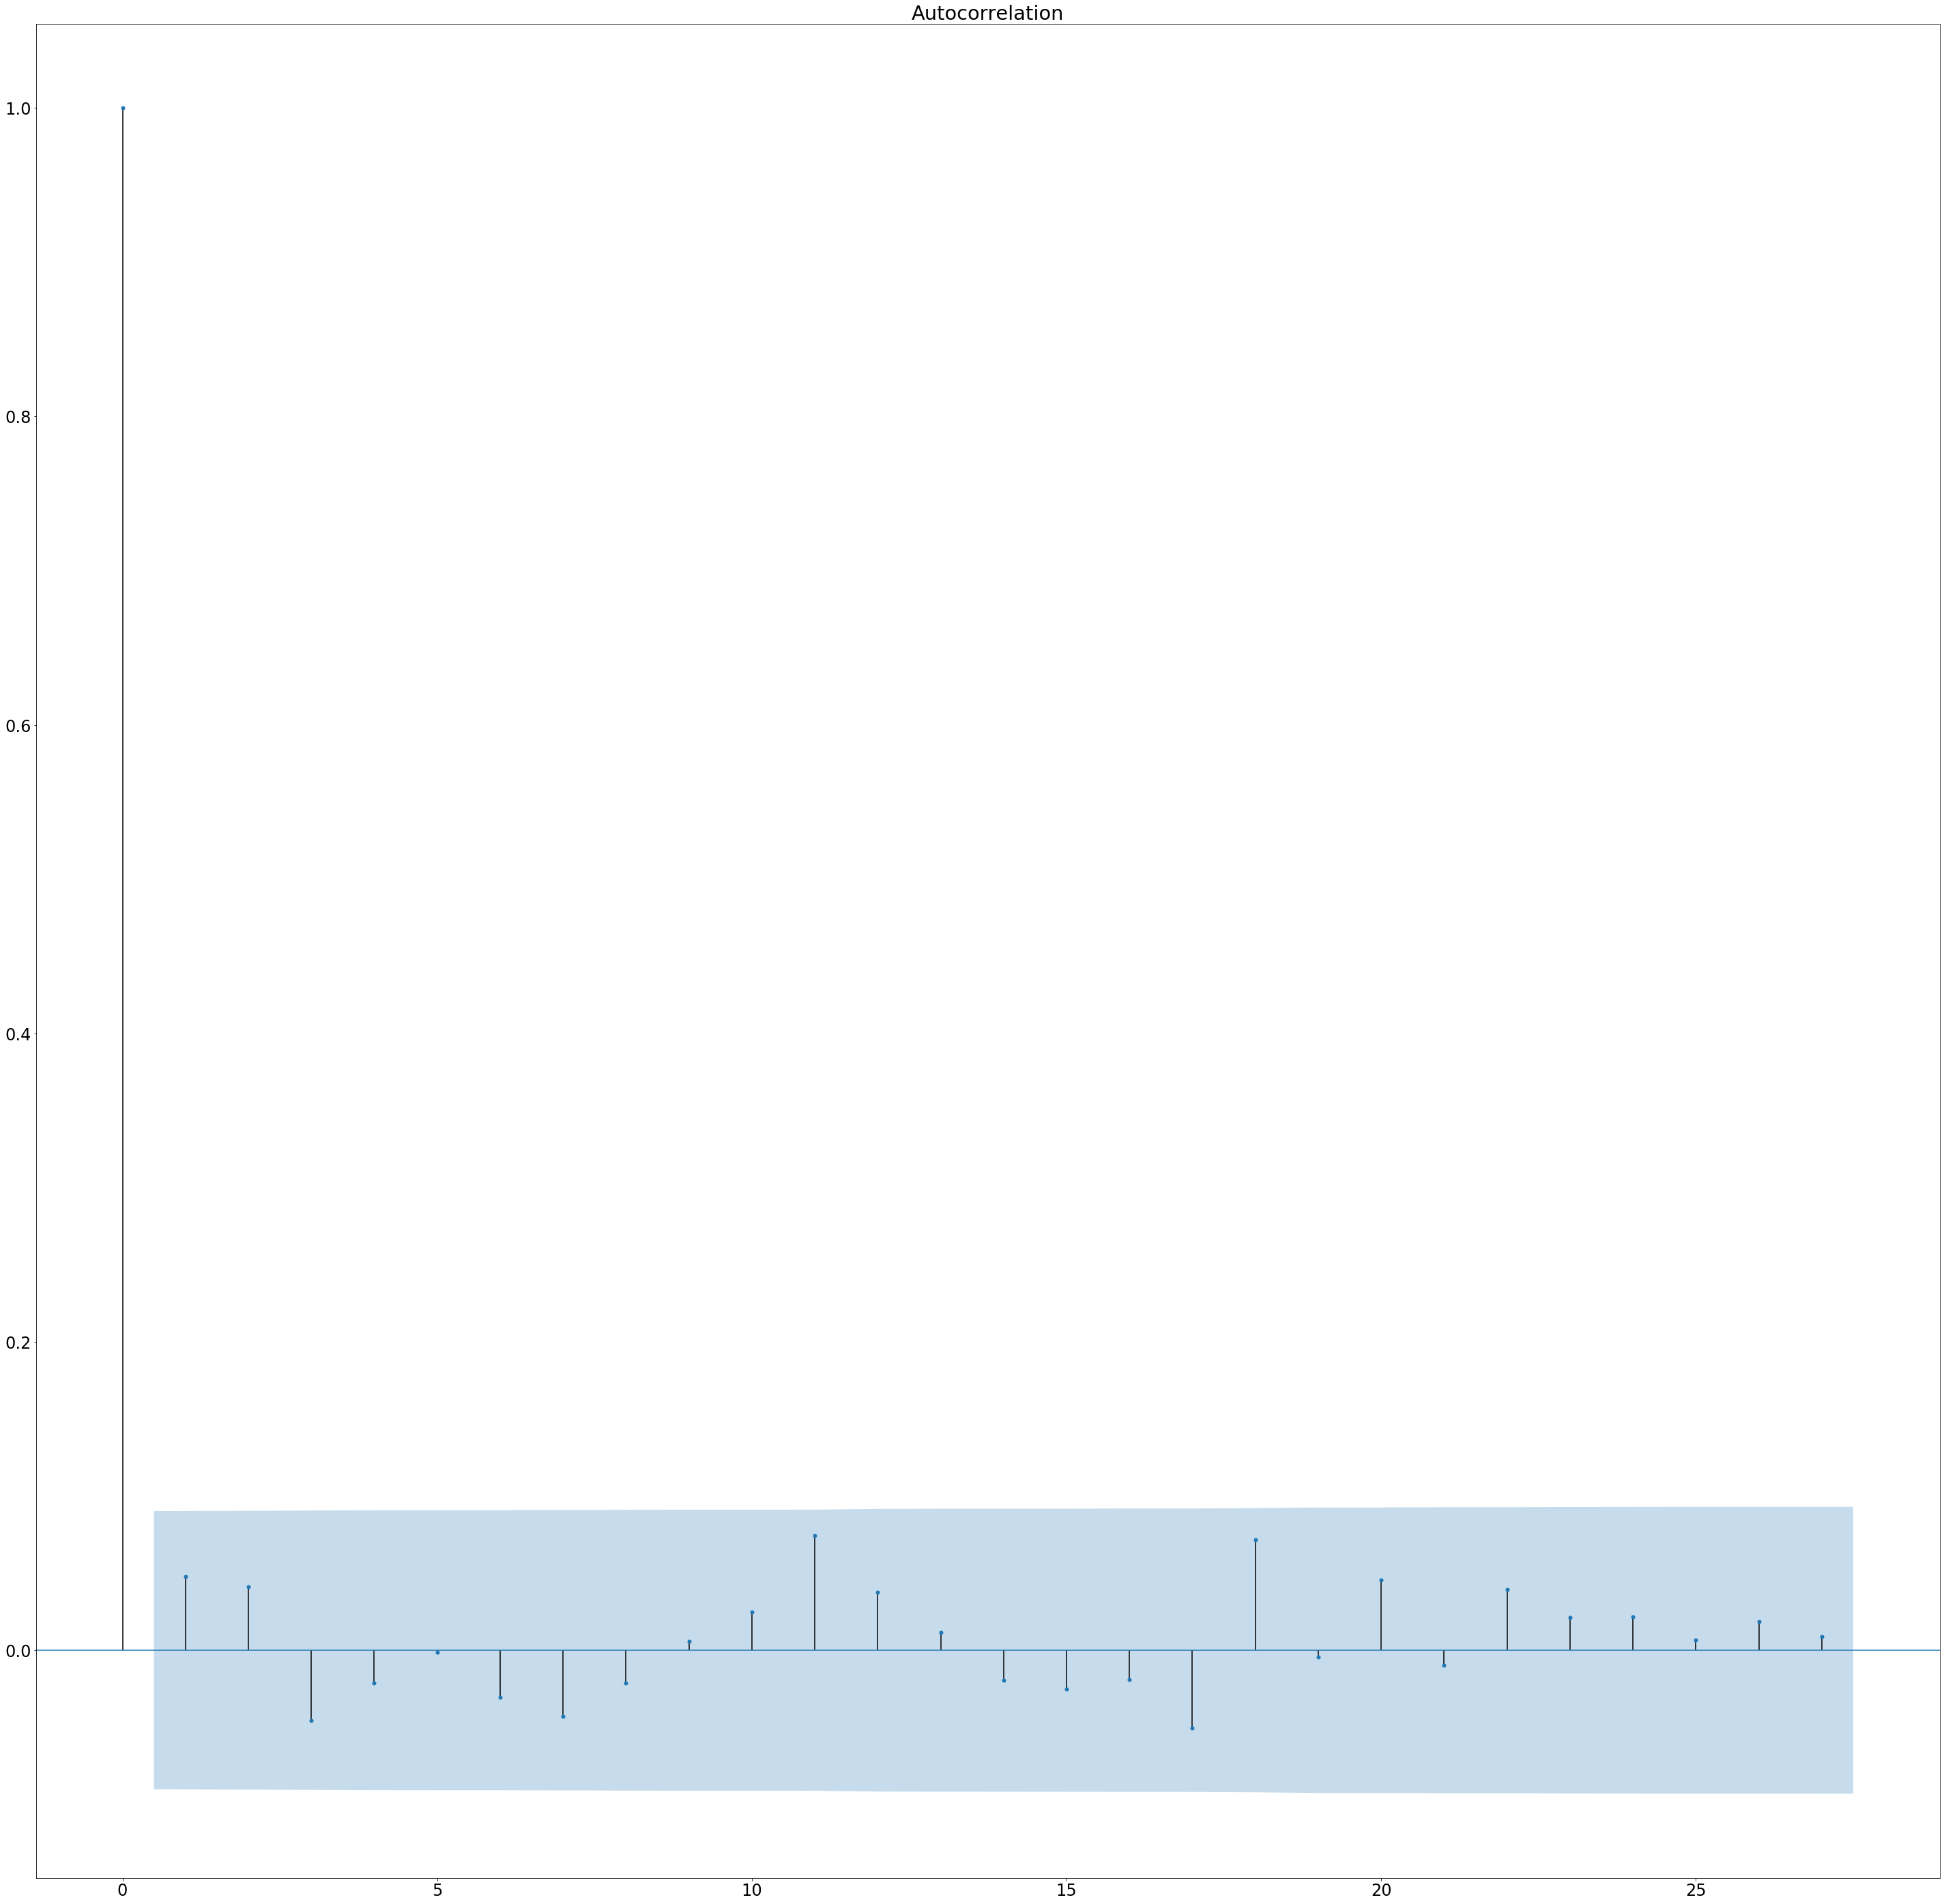

In [17]:
autocorr(rd['RALEIGH, NC'])
plot_acf(rd['RALEIGH, NC'])

### There appear to be correlation peaks located at every prior 12 months. Showing that the previous year's rainfall for that month is correlated to that month's rainfall. Next looks at the correlation between the rainfall of the current month to the rainfall of the previous month (lag 1) and the rainfall of the same month from the prior year (lag 12)

In [18]:
def lag_corr(df,lag=1):
    df2 = df.copy()
    cols = df2.columns
    for col in df2.columns:
        df2[col+'_'+str(lag)] = df2[col].shift(lag)
    df2=df2.dropna()
    correlation = df2.corr()
    correlation = correlation.drop(cols, axis=1)
    correlation = correlation.iloc[0:len(cols)]
    return(correlation)  

In [19]:
nc_corr1 = lag_corr(ncrd)
nc_corr1.head() 

,"RALEIGH, NC_1","FAYETTEVILLE, NC_1","ALBEMARLE, NC_1","ARCOLA, NC_1","ASHEBORO, NC_1","BURLINGTON, NC_1","CARTHAGE, NC_1","CHAPEL HILL, NC_1","CLAYTON, NC_1","DUNN, NC_1",...,"JEFFERSON 2 E, NC_1","MOUNT AIRY 2 W, NC_1","NORTH WILKESBORO, NC_1","REIDSVILLE 2 NW, NC_1","TRANSOU, NC_1","W. KERR SCOTT RESV., NC_1","YADKINVILLE 6 E, NC_1","HAYESVILLE 1 NE, NC_1","MURPHY 4ESE, NC_1","KING, NC_1"
"RALEIGH, NC",0.047621,0.120669,0.105312,0.083236,0.040425,0.083265,0.071957,-0.000262,0.085927,0.076142,...,0.121566,0.132089,0.106094,0.075204,0.121140,0.087017,0.079368,0.062214,0.086322,0.082312
"FAYETTEVILLE, NC",0.141248,0.181540,0.153291,0.185778,0.098024,0.098249,0.180901,0.105907,0.164082,0.218869,...,0.110857,0.144419,0.080097,0.131442,0.077382,0.069437,0.114234,0.022490,0.027602,0.115450
"ALBEMARLE, NC",0.113734,0.145394,0.201431,0.161247,0.104614,0.147124,0.121037,0.120702,0.150969,0.138338,...,0.154282,0.146127,0.155511,0.141830,0.149847,0.146994,0.167138,0.092899,0.109139,0.153370
"ARCOLA, NC",0.150230,0.167288,0.141700,0.164033,0.107702,0.145074,0.150343,0.106394,0.139238,0.146462,...,0.116916,0.161923,0.124068,0.120318,0.119657,0.094691,0.137422,0.064139,0.049551,0.140702
"ASHEBORO, NC",0.103339,0.142749,0.149460,0.083975,0.098849,0.110434,0.160186,0.061347,0.142511,0.186509,...,0.172740,0.170341,0.165812,0.135003,0.154433,0.183369,0.166696,0.124640,0.114137,0.154973


In [20]:
lag12ncrd = lag_corr(ncrd,lag=12)
lag12ncrd.head()

,"RALEIGH, NC_12","FAYETTEVILLE, NC_12","ALBEMARLE, NC_12","ARCOLA, NC_12","ASHEBORO, NC_12","BURLINGTON, NC_12","CARTHAGE, NC_12","CHAPEL HILL, NC_12","CLAYTON, NC_12","DUNN, NC_12",...,"JEFFERSON 2 E, NC_12","MOUNT AIRY 2 W, NC_12","NORTH WILKESBORO, NC_12","REIDSVILLE 2 NW, NC_12","TRANSOU, NC_12","W. KERR SCOTT RESV., NC_12","YADKINVILLE 6 E, NC_12","HAYESVILLE 1 NE, NC_12","MURPHY 4ESE, NC_12","KING, NC_12"
"RALEIGH, NC",0.038223,0.067008,0.094457,0.076545,0.047724,0.045759,0.035081,-0.015288,0.112853,0.005232,...,-0.003976,0.066042,0.015937,-0.015742,0.012049,0.026662,0.038353,-0.009417,-0.009486,0.007757
"FAYETTEVILLE, NC",0.047880,0.078318,0.073282,0.089260,0.031588,0.019285,0.067481,0.003982,0.126988,0.055941,...,-0.023347,0.022556,0.064700,0.051308,0.012123,0.086495,0.054237,-0.003599,-0.026861,0.040126
"ALBEMARLE, NC",0.075829,0.121845,0.010365,0.110692,0.028651,0.028073,0.078896,0.068158,0.106297,0.138828,...,-0.005418,-0.001873,0.009568,0.040885,0.013043,0.022246,0.006785,-0.045779,-0.055709,0.032746
"ARCOLA, NC",0.082162,0.112034,0.122428,0.095171,0.066606,0.135669,0.103031,0.039415,0.103826,0.057640,...,0.017899,0.068533,0.061798,0.057432,0.039345,0.050034,0.064595,0.032342,0.003053,0.052926
"ASHEBORO, NC",0.023212,0.032032,-0.024866,0.065383,-0.024499,-0.001489,0.009776,-0.007797,0.049735,0.018220,...,-0.026392,-0.036775,-0.014091,0.011197,-0.005588,0.020465,-0.022196,-0.051667,-0.049218,-0.029851


In [21]:
# must run Data Wrangling report first and save the dictionary from there. At the very bottom of the report it 
# stores the exogenous locations as a dictionary. The target location is the key with the exogenous locations 
# as a list of strings of the exogenous locations name. 
import json
try:
    %store -r exogen
except NameError:              # non-jupyter environments
    f = open(os.path.join('..','data', 'manipulated_data','exogen.json'),'r')
    exogen = json.load(f)      # read from file, passed from Data_Wrangling
    f.close()

In [22]:
exogen.keys()

dict_keys(['ARCOLA, NC', 'HENDERSON 2 NNW, NC', 'LAURINBURG, NC', 'ROANOKE RAPIDS, NC', 'MURFREESBORO, NC', 'LUMBERTON AREA, NC', 'LONGWOOD, NC', 'WHITEVILLE 7 NW, NC', 'CHARLOTTE AREA, NC', 'MOUNT MITCHELL AREA, NC', 'ASHEVILLE AIRPORT, NC', 'BANNER ELK, NC', 'BEECH MOUNTAIN, NC', 'BRYSON CITY 4, NC', 'BREVARD, NC', 'CASAR, NC', 'COWEETA EXP STATION, NC', 'CULLOWHEE, NC', 'FOREST CITY 8 W, NC', 'FRANKLIN, NC', 'GASTONIA, NC', 'GRANDFATHER MTN, NC', 'HENDERSONVILLE 1 NE, NC', 'HIGHLANDS, NC', 'HOT SPRINGS, NC', 'LAKE LURE 2, NC', 'LAKE TOXAWAY 2 SW, NC', 'MARSHALL, NC', 'MONROE 2 SE, NC', 'MOUNT HOLLY 4 NE, NC', 'OCONALUFTEE, NC', 'PISGAH FOREST 3 NE, NC', 'ROBBINSVILLE AG 5 NE, NC', 'ROSMAN, NC', 'SHELBY 2 NW, NC', 'TAPOCO, NC', 'TRYON, NC', 'WAYNESVILLE 1 E, NC', 'BOONE 1 SE, NC', 'DANBURY, NC', 'EDEN, NC', 'MOUNT AIRY 2 W, NC', 'REIDSVILLE 2 NW, NC', 'HAYESVILLE 1 NE, NC', 'MURPHY 4ESE, NC', 'KING, NC'])

### Below shows one location with its exogenous variables as the lag 1

In [23]:
def exolag(df, location, lag=1):
    df2 = df.copy()
    lt = exogen[location]
    lt2 = lt.copy()
    lt2.append(location)
    locdf = df2[lt2]
    exol = lag_corr(locdf, lag=lag)
    return(exol)
exolag(rd, 'ARCOLA, NC')

,"JOHN KERR DAM, VA_1","ARCOLA, NC_1"
"JOHN KERR DAM, VA",0.137407,0.130182
"ARCOLA, NC",0.123052,0.164033


In [24]:
exolag(rd, 'ARCOLA, NC', lag=12)

,"JOHN KERR DAM, VA_12","ARCOLA, NC_12"
"JOHN KERR DAM, VA",0.006639,0.053618
"ARCOLA, NC",0.039842,0.095171


## Sarima Model

### Step 1 - fitting the model to the data

In [25]:
def sarima_model_creation(data, p, d, q, P, D, Q, m, exog=None):
    my_order = [p,d,q]
    my_sorder = [P,D,Q,m]
    sarimamod = sm.tsa.statespace.SARIMAX(data, exog, order=my_order, seasonal_order=my_sorder, 
                                          enforce_stationarity=False, enforce_invertibility=False,
                                          initialization='approximate_diffuse')
    model_fit = sarimamod.fit()# start_params=[0, 0, 0, 0, 1])
    return(model_fit)  

### Step 2 - separating the training, validation, and test data

In [26]:
training = rd['RALEIGH, NC'].iloc[0:376]
validation = rd['RALEIGH, NC'].iloc[376:424]
# used to train the model during the test of the never before seen test data
test_training = rd['RALEIGH, NC'].iloc[0:424] 
testing = rd['RALEIGH, NC'].iloc[424:]

### Step 3 - Creating a baseline forecast, without the training

In [27]:
baseline = sarima_model_creation(training, 0,0,0,0,0,0,12)
baseline.forecast()

2011-05-01    0.0
Freq: MS, dtype: float64

### Step 4 - Finding the hyperparameters

In [28]:
def iteration_hyper(it):
    ''' This function takes a number and creates a list of lists that each contain a number from zero to the 
    provided number (it)
    '''
    outlist = []
    for AR in range(it):
        for MA in range(it):
            for SAR in range(it):
                for SMA in range(it):
                    outlist.append([AR,MA,SAR,SMA])
    return(outlist)
        
config = iteration_hyper(5) # creates all possible numbers for each parameter from 0-4

In [29]:
def hyperparameter_find(training_data, comb, testing_data):
    ''' this function uses the training data and testing data to find out which combination of hyperparameters
    best predicts the following months rainfall.
    '''
    leastmae = 1000
    for com in comb:
        li_one_step = []
        for i in range(len(testing_data)): # iterate through the testing data
            if i is not 0:
                # create a model from all the data that includes the addition of the actual rainfall amount
                # from the previous month
                mod_1 = sarima_model_creation(copytraining, com[0], 0, com[1], com[2], 0, com[3], 12)
                one_step_pred = mod_1.forecast() # make the prediction for the next month
                li_one_step.append(one_step_pred[0]) # save prediction to a list
                copytraining = pd.concat([copytraining, testing_data[[i]]]) # add the true rainfall value
            else:
                copytraining = training_data.copy() # make a copy of the dataset
                mod_1 = sarima_model_creation(copytraining, com[0], 0, com[1], com[2], 0, com[3], 12)
                one_step_pred2 = mod_1.forecast()
                li_one_step.append(one_step_pred2[0])
                copytraining = pd.concat([copytraining, testing_data[[i]]])
        # find the mean absolute error between the what the rainfall was and what the model predicted it to be        
        mae = mean_absolute_error(testing_data, li_one_step) 
        if mae < leastmae:
            leastmae = mae
            H_AR = com[0]
            H_MA = com[1]
            H_SAR = com[2]
            H_SMA = com[3]
        print(com,mae) # due to the length of time this function takes to run, this provides an update of each
        # combination and the Mean Absolute error for that model run with the given parameters
    return('AR: '+ str(H_AR), 'MA: ' +str(H_MA), 'SAR: '+str(H_SAR), 'SMA: '+str(H_SMA))

In [30]:
# this cell takes a very long time to run as there are 625 different possiblities. DO NOT UN-Comment and run all
# hyperparameter_find(training, config, validation)

The best hyperparameters for this data set were: p=4, d=0, q=3, P=3, D=0, Q=4, m=12

    p: Trend autoregression order.
    d: Trend difference order.
    q: Trend moving average order.
    P: Seasonal autoregressive order.
    D: Seasonal difference order.
    Q: Seasonal moving average order.
    m: The number of time steps for a single seasonal period.

testing model on never before seen data

In [31]:
best_comb = [[4,3,3,4]]
# the results of the following statement is shown below, takes a bit to run
#hyperparameter_find(test_training, best_comb, testing)

Mean Absolute Error for training data = 1.23234368392907 Mean Absolute Error for Testing data = 1.8150609730404315

### Step 5 - Determining if any exogenous (external) locations outside of NC will increase the performace of the model

I created a library of functions that will be used to evaluate an location and its exogenous locations.  These functions first break into parallel processes to evaluate multiple exogenous MAE's at once.  The model creation and prediction uses recursive iterations for efficient memory management to then bubble up and store any improved MAE into a dictionary.

In [32]:
def model_creation_pred_one_step(train_data, test_data, exotrain=None, exotest=None, progress_bar=None):
    ''' recursively makes forecast based on provided data for the next month
        args: train_data = large data set to base predictions on
              test_data  = decreasing dataset of data to test model
              exotrain   = exogenous location data that matches the same timeframe of train_data but was not included
              exotest    = exogenous location data that matches the same timeframe of test_data but was not included
        returns: A list of all predictions for the location matching the entire test_data timeframe
    '''
    list_one_step = []
    
    nextMonth = model_based_forecast(train_data, exotrain)
    list_one_step.append(nextMonth[0])             # captures prediction
    progress_bar.update()

    # if test data exists
    if len(test_data) > 1:
        # increment data for next month's iteration
        train_data = pd.concat([train_data, test_data.iloc[[0]]])
        test_data = test_data.drop(test_data.index[0], axis = 0)
        if exotrain is not None:
            exotrain = pd.concat([exotrain, exotest.iloc[[0]]])
            exotest = exotest.drop(exotest.index[0], axis = 0)

        # execute & capture future predictions
        futurePredictions = model_creation_pred_one_step(train_data, test_data, exotrain, exotest, progress_bar)
        # add to list
        list_one_step.extend(futurePredictions)
        
    return(list_one_step)


def model_based_forecast(train_data, exotrain=None):
    ''' creates model from training data & makes a forecast
        args: train_data = DataFrame to build forecasting model
              exotrain   = DataFrame of exogenous location's rainfall data
        returns: FLOAT value of next month's forecast value
    '''
    mod = sarima_model_creation(train_data, 4, 0, 3, 3, 0, 4, 12, exotrain)
    # if exists, passing exotrain's prevMonth (december, for forecasting jan), otherwise only forcast based on model
    nextMonth = mod.forecast() if exotrain is None else mod.forecast(exog=exotrain.iloc[[-1]])       # turnary assignment expression
    return(nextMonth)


import copy

def maeFinder(train_data, test_data, exotrain=None, exotest=None, pbar=None):
    ''' Function that finds the Mean Absolute Error between test_data and model-based predictions
        args: train_data = large data set to base predictions on
              test_data  = decreasing dataset of data to test model
              exotrain   = exogenous location data that matches the same timeframe of train_data but was not included
              exotest    = exogenous location data that matches the same timeframe of test_data but was not included
              pbar       = Progress Bar object from tqdm, to provide updates to
        returns: FLOAT of Mean Absolute Error value of potential exogenous location when included into model
    '''
    clone_train_data = copy.deepcopy(train_data)
    clone_test_data = copy.deepcopy(test_data)
    clone_exotrain = None if exotrain is None else copy.deepcopy(exotrain)
    clone_exotest = None if exotest is None else copy.deepcopy(exotest)
    
    pbar = pbar if pbar is not None else tqdm(total=len(test_data)) # initialize counter
    
    predictions = model_creation_pred_one_step(clone_train_data, clone_test_data, clone_exotrain, clone_exotest, pbar)
    mae = mean_absolute_error(test_data, predictions)
    return(mae)


def find_exmae(exog, bettermae):
    ''' Standalone task method to find mae of a given exogenous variable.  
        Intended to be used as the function for the process pool and handle memory synchronization
        args: exog = exogenous location data to be evaluated as a potential associated location to model
              bettermae = List of new locations with better exmaes than the current keymae
        returns: Dictionary of exmae with columns
        #bettermae state is updated synchronously across all forked processes
    '''
    extr, extest = train_test_split(exog, test_size=0.2, shuffle=False)
    exmae = maeFinder(tr, test, extr, extest, pbar)
    co = tuple(exog.columns)
    if exmae < keymae:
        lock.acquire()  # process sychronization lock
        try:
            bettermae[co] = exmae
            bettermae2 = {key: bettermae}
        finally:
            lock.release()  # process synchronization release
        
    return { "co": co, "exmae": exmae }


def initExmaeWorker(l, kmae, train, testing, list_exoloc, progress_bar):
    ''' Constructor function for creating and establishing initial/global 
        variables across process pool.
        args: l = synchronization lock object
              kmae = global keymae value
              train = training dataframe object to use across processes
              testing = testing dataframe object to use across processes
              list_exoloc = list of exogenous locations related to target location
              progress_bar = tqdm object for visual progress updates
    '''
    global lock
    global keymae
    global tr
    global test
    global l_exoloc
    global pbar
    lock = l
    keymae = kmae
    tr = train
    test = testing
    l_exoloc = list_exoloc
    pbar = progress_bar


import multiprocessing

def exogenous_var(data, ncloc, l_exoloc):
    ''' Function to evaluate an location model completely.  First, it finds
        a keymae of the current data frame about a location with 20% data split.
        Secondly, it spawns a pool of processes (# of CPU cores) to calculate each potential
        exogenous location's potential improvement of the model.  Each exmae is printed to
        stdout and if improved, it is stored into the bettermae dictionary.  The NC location
        does not complete until all exmaes have been calculated.
        args: data  = entire dataframe of locations and rainfall amounts over time
              ncloc = Name of NC location (matches column in data)
              l_exoloc = list of exogenous locations to the ncloc parameter
    '''
    dat = data[ncloc]
    tr, test = train_test_split(dat, test_size=0.2, shuffle=False)
    keymae = maeFinder(tr, test)
    print('keymae of: '+ key +' = '+str(keymae))
    bettermae = {}
    bettermaeLock = multiprocessing.Lock()
    
    def on_success(result):
        print('exmae = {}'.format(result["co"]) + ' '+ str(result["exmae"]))
        progressbar.update() # update counter of completion
    
    def on_error(err):
        print(err)
        pass
    
    process_limit = multiprocessing.cpu_count()
    progressbar = tqdm(total=len(l_exoloc))  # initialize counter
    pool = multiprocessing.Pool(processes=process_limit, initializer=initExmaeWorker, initargs=(bettermaeLock, keymae, tr, test, l_exoloc, progressbar))
    for exog in l_exoloc:
        pool.apply_async(find_exmae, args=(exog, bettermae), kwds={}, callback=on_success, error_callback=on_error)
    
    pool.close()      # no more tasks can be added for the pool to accomplish
    pool.join()       # tell parent to wait until all tasks are accomplished by the process pool

    return()


In [33]:
def exog_combinations(df, exoe):
    ''' This function takes the dataframe of rain data and the list of exogenous variables from a single NC
    location and then returns a list of dataframes that contains all of the rainfall data for just the 
    exogenous variables
    '''
    lo_dfs = []
    if len(exoe) == 1:
        lo_dfs.append(df.loc[:,exoe])
    if len(exoe) > 1:
        lo_dfs.append(df.loc[:,exoe])
        for ex in exoe:
            lo_dfs.append(df.loc[:,[ex]])
        if len(exoe) >2:
            for i in range(2, len(exoe)):
                combolist = list(combinations(exoe,i))
                for c in combolist:
                    lo_dfs.append(df.loc[:,c])
    return(lo_dfs)

Using the previous function, it is placed into a for loop which creates a full list of dataframes for every location and exogenous location.

In [34]:
l_o_dfs = defaultdict(list)
for key,value in tqdm(exogen.items()):
    lo_dfs2 = exog_combinations(rd, value)
    l_o_dfs[key] = lo_dfs2
l_o_dfs['LONGWOOD, NC']

[            LORIS 2 S, SC  MYRTLE BEACH AREA, SC
 Date                                            
 1980-01-01       4.220000                 4.4375
 1980-02-01       2.100000                 2.0825
 1980-03-01       8.240000                 7.9225
 1980-04-01       1.400000                 1.7625
 1980-05-01       4.520000                 3.9300
 1980-06-01       4.670000                 3.4900
 1980-07-01       1.960000                 4.3800
 1980-08-01       2.270000                 2.2325
 1980-09-01       4.370000                 4.5650
 1980-10-01       1.550000                 1.9775
 1980-11-01       1.650000                 1.7225
 1980-12-01       3.120000                 3.2300
 1981-01-01       0.950000                 0.9850
 1981-02-01       2.650000                 2.5425
 1981-03-01       3.700000                 3.6425
 1981-04-01       0.780000                 1.1600
 1981-05-01       4.710000                 5.5375
 1981-06-01       3.940000                 5.9275


the following for loop goes through all of the NC locations and creates a model and finds the performance of
the model using Mean Absolute Error. It then goes through includes each of the possible combinations of the 
location's exogenous variables and creates a model and determines the performance of the model. Thus, it makes a model for all 46 locations with exogenous locations that are within 50 kilometers. Then it creates a model for one of the 46 target locations including their exogenous locations. If a target location has one exogenous location, then it will create one model for the target location and one for the target location with the exogenous variable included. However, if the target location has 2 or more exogenous locations it will still create a model for the target and a model for the target with each exogenous variable included. However, it will also include a forth model that creates a model with the target, target and both exogenous locations. Greater than 2 exogenous locations will also include every possible combination of the exogenous locations as separate models. All models are evaluated by Mean Absolute Error. 

In [35]:
# for key,value in tqdm(l_o_dfs.items()):
#     exogenous_var(rd, key, value)

Only 8 of the 46 locations performed better including the exogenous variables, and are listed below: 
'WHITEVILLE 7 NW, NC', 'CASAR, NC', 'FOREST CITY 8 W, NC', 'GASTONIA, NC', 'LAKE LURE 2, NC', 
                       'ELIZABETHTOWN, NC', ' MOUNT HOLLY 4 NE, NC','GRANDFATHER MTN, NC'

### Step 6 - Predictions

Only 8 locations had exogenous variables that increased the performance of the model; therefore, a majority of the locations could be run for predictions only including the locations' rainfall data. 

In [36]:
# removal of locations that have exogenous variables
with_exogs = ['WHITEVILLE 7 NW, NC', 'CASAR, NC', 'FOREST CITY 8 W, NC', 'GASTONIA, NC', 'LAKE LURE 2, NC', 
                       'ELIZABETHTOWN, NC', 'MOUNT HOLLY 4 NE, NC','GRANDFATHER MTN, NC']
ncrd2 = ncrd.copy()
ncrd_less = ncrd2.drop(with_exogs,axis=1)

In [37]:
def prediction_fx(data, begin, end):
    ''' this function uses the dataframe without exogenous variables and creates a model, fits the model, and 
    then predicts the next 50 years of rainfall data as both a point prediction and a confidence interval
    '''
    base = datetime.strptime(begin,'%Y-%m-%d')
    date_list = [base + relativedelta(months=x) for x in range(600)]
    prediction1_df = pd.DataFrame(index=date_list)
    for col in tqdm(data.columns):
        loc = data[col]
        mod_fit1 = sarima_model_creation(loc, 4,0,3,3,0,4,12)
        point_predictions = pd.DataFrame(mod_fit1.predict(start=begin, end=end), columns=[col])
        future_pred1 = mod_fit1.get_prediction(start=begin, end=end)
        future_pred1_ci = future_pred1.conf_int(alpha=0.5)
        point_predictions_df = pd.merge(point_predictions, future_pred1_ci, left_index=True, right_index=True)
        prediction1_df = pd.merge(prediction1_df, point_predictions_df, left_index=True, right_index=True)
    return(prediction1_df)

In [38]:
#pre_df = prediction_fx(ncrd_less, '2019-05-01', '2069-05-01')

In [39]:
exo_var_dict2 = {
    'WHITEVILLE 7 NW, NC': rd[['LORIS 2 S, SC']],
    'CASAR, NC': rd[['GAFFNEY 6 E, SC']],
    'FOREST CITY 8 W, NC': rd[['GAFFNEY 6 E, SC']],
    'GASTONIA, NC': rd[['FORT MILL 4 NW, SC','GAFFNEY 6 E, SC']],
    'LAKE LURE 2, NC': rd[['CHESNEE 7 WSW, SC']],
    'MOUNT HOLLY 4 NE, NC': rd[['CHESNEE 7 WSW, SC','GAFFNEY 6 E, SC']],
    'ELIZABETHTOWN, NC': rd[['LORIS 2 S, SC']],
    'GRANDFATHER MTN, NC': rd[['ELIZABETHTON, TN']]
    
}

In [40]:
def prediction_exog_fx2(data, exog_dict, begin, end):
    ''' this function uses the dataframe out exogenous variables and creates a model, fits the model, and 
    then predicts the next 50 years of rainfall data as both a point prediction and a confidence interval
    '''
    base = datetime.strptime(begin,'%Y-%m-%d')
    date_list = [base + relativedelta(months=x) for x in range(600)]
    prediction_df = pd.DataFrame(index = date_list)
    pred_val_df = pd.DataFrame(index = date_list)
    exog_predictions_df = pd.DataFrame(index = date_list)
    for key,value in tqdm(exog_dict.items()):
        loc = data[key]
        mod_fit1 = sarima_model_creation(loc, 4,0,3,3,0,4, 12,exog=value)
        if value.shape[1] > 1:
            shap = value.shape[1]
            for i in range(shap):
                exog_mod_fit = sarima_model_creation(value.iloc[:,i],4,0,3,3,0,4,12)
                e_preds2 = pd.DataFrame(exog_mod_fit.predict(start=begin, end=end))
                if i is 0:
                    exog_predictions_df = e_preds2
                else:
                    exog_predictions_df = pd.merge(exog_predictions_df, e_preds2, left_index=True, 
                                                   right_index=True)
        else:
            exog_mod_fit = sarima_model_creation(value, 4,0,3,3,0,4,12)
            exog_predictions_df = pd.DataFrame(exog_mod_fit.predict(start=begin, end=end))
        future_pred = mod_fit1.get_prediction(exog=exog_predictions_df,start=begin, end=end)
        future_pred_ci = future_pred.conf_int(alpha=0.5)
        future_pred_val= pd.DataFrame(mod_fit1.predict(exog=exog_predictions_df, start=begin, end=end), 
                                      columns = [key])
        future_pred_full = pd.merge(future_pred_val, future_pred_ci, left_index=True, right_index=True)
        prediction_df = pd.merge(prediction_df, future_pred_full, left_index=True, right_index=True)
    return(prediction_df)

In [41]:
# e_ci_df = prediction_exog_fx2(rd, exo_var_dict2, '2019-05-01', '2069-05-01')

In [42]:
# merged_ci_vals = pd.merge(pre_df, e_ci_df, left_index=True, right_index=True)
# merged_ci_vals.head(10)

In [43]:
# merged_ci_vals.to_csv('../data/manipulated_data/predictions.csv')

In [44]:
predictions = pd.read_csv('../data/manipulated_data/predictions.csv', index_col=['Unnamed: 0'])
predictions.head(10)

,"RALEIGH, NC","lower RALEIGH, NC","upper RALEIGH, NC","FAYETTEVILLE, NC","lower FAYETTEVILLE, NC","upper FAYETTEVILLE, NC","ALBEMARLE, NC","lower ALBEMARLE, NC","upper ALBEMARLE, NC","ARCOLA, NC",...,"upper LAKE LURE 2, NC","MOUNT HOLLY 4 NE, NC","lower MOUNT HOLLY 4 NE, NC","upper MOUNT HOLLY 4 NE, NC","ELIZABETHTOWN, NC","lower ELIZABETHTOWN, NC","upper ELIZABETHTOWN, NC","GRANDFATHER MTN, NC","lower GRANDFATHER MTN, NC","upper GRANDFATHER MTN, NC"
2019-05-01,3.366825,1.882192,4.851458,3.101341,1.511192,4.691489,3.479119,1.974462,4.983777,4.085681,...,8.313480,3.731719,2.817627,4.645811,4.469158,2.961440,5.976875,7.392983,5.478073,9.307893
2019-06-01,4.311777,2.826668,5.796886,4.640029,3.037656,6.242402,4.785953,3.261386,6.310519,4.376612,...,6.642947,3.883787,2.965665,4.801909,4.588221,3.049861,6.126580,6.589118,4.667555,8.510681
2019-07-01,6.315169,4.828482,7.801856,4.714777,3.112173,6.317381,5.192788,3.656307,6.729269,4.050988,...,6.506239,3.581252,2.661533,4.500971,5.736685,4.196167,7.277203,7.273827,5.352017,9.195636
2019-08-01,4.145769,2.653249,5.638289,5.171312,3.567914,6.774711,4.520501,2.976974,6.064027,3.883282,...,7.123837,3.462790,2.535717,4.389863,6.705314,5.164617,8.246012,6.478766,4.556957,8.400576
2019-09-01,4.875788,3.383246,6.368330,4.583295,2.977904,6.188687,3.564789,2.021157,5.108421,4.530033,...,7.058412,3.214416,2.287192,4.141640,8.096275,6.555570,9.636979,5.790845,3.868984,7.712706
2019-10-01,4.620944,3.125610,6.116278,3.443512,1.837888,5.049137,3.678940,2.134648,5.223231,4.208592,...,6.627989,3.445445,2.518053,4.372837,4.997616,3.456859,6.538373,5.585516,3.663655,7.507378
2019-11-01,2.836176,1.338344,4.334008,2.830567,1.224550,4.436585,3.572469,2.027956,5.116982,4.116032,...,6.180580,3.299821,2.368343,4.231298,4.436358,2.895585,5.977131,5.538783,3.616878,7.460689
2019-12-01,3.028362,1.529993,4.526731,3.044494,1.438274,4.650715,3.955301,2.410763,5.499838,4.111410,...,6.774645,3.797539,2.865930,4.729148,4.469746,2.928962,6.010531,6.105778,4.183864,8.027692
2020-01-01,3.996224,2.495057,5.497391,2.894629,1.288313,4.500945,2.988096,1.443488,4.532703,3.861018,...,6.301527,3.375624,2.444017,4.307232,4.478463,2.937648,6.019278,5.590907,3.668951,7.512862
2020-02-01,2.822260,1.320547,4.323973,2.764487,1.158102,4.370872,3.182667,1.638126,4.727209,3.847665,...,6.547984,3.435553,2.501669,4.369436,5.144224,3.603394,6.685055,5.905106,3.983133,7.827079


In [45]:
sub_pred = predictions[:120]

In [46]:
plt.rcParams["figure.figsize"] = (60,15)
plt.rcParams["font.size"] = 32.0

In [47]:
predictions.index = pd.to_datetime(predictions.index)
low_vals = np.array(predictions['lower RALEIGH, NC'])
upper_vals = np.array(predictions['upper RALEIGH, NC'])
point_vals = np.array(predictions['RALEIGH, NC'])
upper_error = upper_vals - point_vals
lower_error = point_vals - low_vals

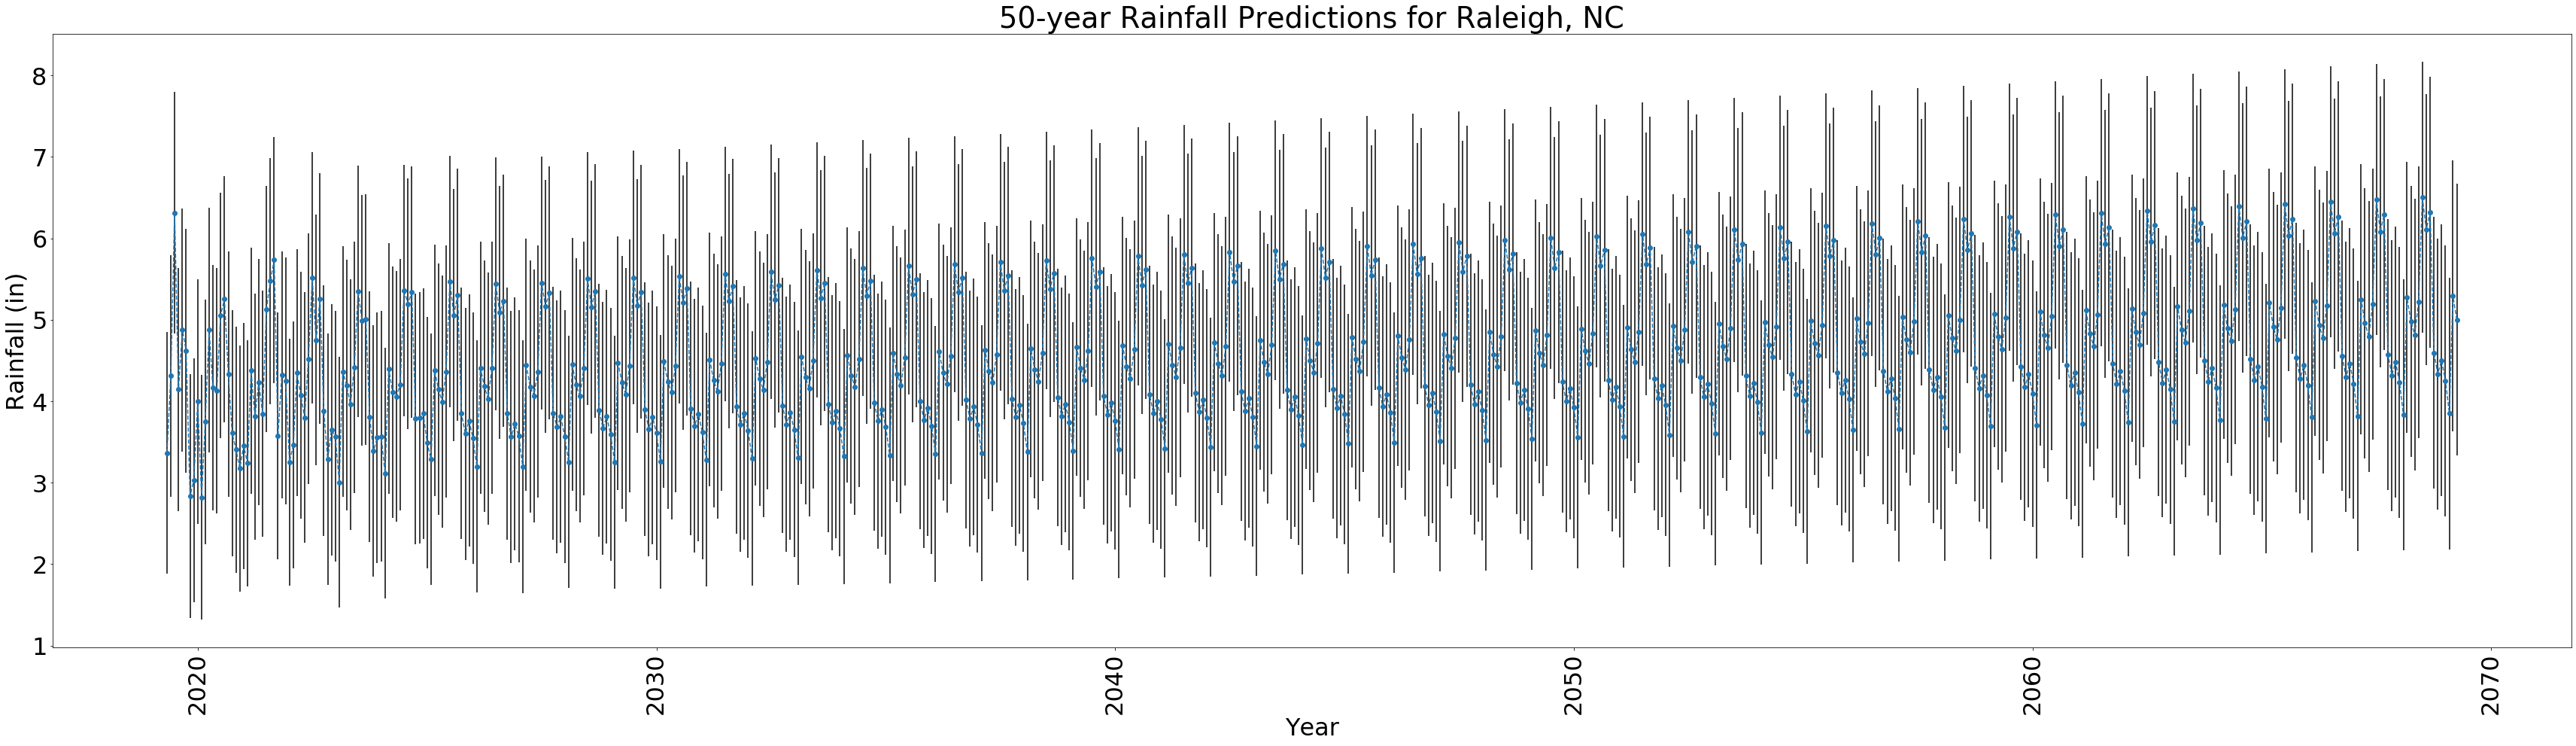

In [48]:
# _= plt.plot(predictions.index, predictions['Raleigh, NC'], marker = 'o')
_= plt.errorbar(predictions.index, predictions['RALEIGH, NC'], yerr=[lower_error, upper_error],
               fmt='--o', ecolor='k', capthick=5)
_= plt.xticks(rotation='vertical')
_=plt.xlabel('Year')
_=plt.ylabel('Rainfall (in)')
_=plt.title('50-year Rainfall Predictions for Raleigh, NC')
plt.savefig('Raleigh_predictions.jpg')
plt.show()

In [49]:
locs = list(ncrd.columns)

In [50]:
latlongsplit = latlong.iloc[0].apply(str.split, sep=',')
latlongdf = pd.DataFrame(latlongsplit)
latlongdf = latlongdf.drop(['Unnamed: 0'])
latlongdf_index = list(latlongdf.index)
for idx, name in enumerate(latlongdf_index):
    latlongdf_index[idx] = name.upper().strip()
latlongdf.index = latlongdf_index
latlongdf3 = pd.DataFrame(latlongdf[0].values.tolist(), columns=['Latitude','Longitude'], index = 
                          latlongdf.index)
latlongdf3 = latlongdf3.drop(['RALEIGH AP, NC', 'GREENSBORO, NC', 'WILMINGTON 7 N, NC','LUMBERTON, NC',
                              'MYRTLE BEACH, SC','CHARLOTTE DOUGLAS AIRPORT, NC','GRNVL SPART INTL AP, SC',
                              'PICKENS, SC','MT. MITCHELL, NC','CAESARS HEAD AREA, SC'])
latlongdf4 = latlongdf3.loc[locs]
latlongdf4.head()

,Latitude,Longitude
"RALEIGH, NC",35.881009,-78.790957
"FAYETTEVILLE, NC",35.032980,-78.872576
"ALBEMARLE, NC",35.356981,-80.200313
"ARCOLA, NC",36.288210,-77.980031
"ASHEBORO, NC",35.705573,-79.814316


In [51]:
nc_locs = predictions.loc[:,locs]
trans_nc_locs = nc_locs.transpose()
latlong_rain = pd.merge(latlongdf4, trans_nc_locs, left_index=True, right_index=True)
latlong_rain.head()

,Latitude,Longitude,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,...,2068-07-01 00:00:00,2068-08-01 00:00:00,2068-09-01 00:00:00,2068-10-01 00:00:00,2068-11-01 00:00:00,2068-12-01 00:00:00,2069-01-01 00:00:00,2069-02-01 00:00:00,2069-03-01 00:00:00,2069-04-01 00:00:00
"RALEIGH, NC",35.881009,-78.790957,3.366825,4.311777,6.315169,4.145769,4.875788,4.620944,2.836176,3.028362,...,6.505039,6.108836,6.319625,4.595613,4.335028,4.503430,4.251635,3.850801,5.295896,5.001006
"FAYETTEVILLE, NC",35.032980,-78.872576,3.101341,4.640029,4.714777,5.171312,4.583295,3.443512,2.830567,3.044494,...,4.487503,4.763604,4.390807,2.976458,2.619089,2.834067,2.692395,2.503302,2.967528,2.817380
"ALBEMARLE, NC",35.356981,-80.200313,3.479119,4.785953,5.192788,4.520501,3.564789,3.678940,3.572469,3.955301,...,3.944345,3.511335,3.295444,2.480173,2.470645,2.642122,2.754469,2.453668,3.245712,2.697018
"ARCOLA, NC",36.288210,-77.980031,4.085681,4.376612,4.050988,3.883282,4.530033,4.208592,4.116032,4.111410,...,4.368258,4.368850,4.369442,4.370034,4.370626,4.371218,4.371811,4.372403,4.372995,4.373588
"ASHEBORO, NC",35.705573,-79.814316,3.473868,3.921050,5.213219,3.464082,4.464706,4.084354,3.449393,3.468123,...,3.889439,3.806277,5.242005,3.428361,3.575363,3.754081,3.366264,3.125712,3.754501,3.849365


In [52]:
import gmplot

In [53]:
from IPython.display import IFrame
gmap = gmplot.GoogleMapPlotter(35.881009, -78.790957, 7.5,apikey=APIKEY)
latitudes = latlong_rain['Latitude'].astype(float)
longitudes = latlong_rain['Longitude'].astype(float)

location_rainfall_by_month = {}
dates = latlong_rain.columns[2:] # remove lat and long
for date in dates:
    rainfall_amt = latlong_rain[date]
    timestamp = str(datetime.timestamp(datetime.strptime(str(date),'%Y-%m-%d %H:%M:%S'))*1000)  # ms
    location_rainfall_by_month[timestamp] = []
    latlong_rain_index = list(latlong_rain.index)
    for idx in latlong_rain_index:
        location_rainfall_by_month[timestamp].append({
            'Latitude': latitudes[idx],
            'Longitude': longitudes[idx],
            'weight': rainfall_amt[idx]
        })

# Overlay our datapoints onto the map
gmap.heatmap_points = location_rainfall_by_month
gmap.settings_string = gmap._process_heatmap_kwargs({
    'threshold': 10,
    'radius': 30,
    'gradient': None,
    'opacity': 0.6,
    'maxIntensity': 25,
    'dissipating': True
})
# Comment out these 3 following lines if you want data all inside 1 file, debuggers fail at large file size
gmap.data_external = True
with open('data.js','w') as datafile:
    datafile.write('var dataPointsByMonth = '+json.dumps(location_rainfall_by_month, indent=4)+';\n')

# Generate the heatmap into an HTML file
gmap.draw('nc_heatmap.html')

IFrame(src='nc_heatmap.html', width=1000, height=600)


File creation completed!
